# Cuadratura Gaussiana

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [2]:
x = sym.Symbol('x',real=True)
y = sym.Symbol('y',real=True)

Seguimos con el problema de integrar una función $f(x)$ en cierto intervalo \[a,b\] mediante su cuadratura. Es decir, realizando una suma con pesos de la función en ciertos nodos

$$\begin{align*}
\int_a^b f(x) dx = \sum_{k=0}^{n-1} c_k f(x_k)
\end{align*}
$$

## Gauss-Legendre

La aproximación de Gauss-Legendre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-1}^1 f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Legendre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
P_n(x) &= \frac{1}{2^n n!} \frac{d^n}{dx^n}(x^2-1)^n
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Legendre.

In [3]:
def GetLegendre(n,x,y):
    
    y = (x**2 - 1)**n
    
    poly = sym.diff( y,x,n )/(2**n*np.math.factorial(n))
    
    return poly

Los polinomios de Legendre también satisfacen la ecuación de recursión

$$
\begin{align*}
(n+1)P_{n+1}(x) &= (2n+1)xP_n(x)-nP_{n-1}(x),
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva.

In [4]:
def GetLegendreRecursive(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = x
    else:
        poly = ((2*n-1)*x*GetLegendreRecursive(n-1,x)-(n-1)*GetLegendreRecursive(n-2,x))/n
   
    return sym.expand(poly,x)

Veamos un ejemplo de estos polinomios para distintos $n$,

In [5]:
GetLegendreRecursive(0,x)

1

In [6]:
GetLegendreRecursive(1,x)

x

In [7]:
GetLegendreRecursive(3,x)

5*x**3/2 - 3*x/2

Para encontrar sus ceros, utilizamos el método de Newton-Rhapson teniendo en cuenta que el $n$-ésimo polinomio tendrá $n$ raíces. Antes de eso, encontremos la derivada de Legendre,

In [8]:
def GetDLegendre(n,x):
    Pn = GetLegendreRecursive(n,x)
    return sym.diff(Pn,x,1)

In [9]:
def GetNewton(f,df,xn,itmax=10000,precision=1e-14):
    
    error = 1.
    it = 0
    
    while error >= precision and it < itmax:
        
        try:
            
            xn1 = xn - f(xn)/df(xn)
            
            error = np.abs(f(xn)/df(xn))
            
        except ZeroDivisionError:
            print('Zero Division')
            
        xn = xn1
        it += 1
        
    if it == itmax:
        return False
    else:
        return xn

In [10]:
def GetRoots(f,df,x,tolerancia = 10):
    
    Roots = np.array([])
    
    for i in x:
        
        root = GetNewton(f,df,i)

        if  type(root)!=bool:
            croot = np.round( root, tolerancia )
            
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots

In [11]:
def GetAllRootsGLeg(n):

    xn = np.linspace(-1,1,100)
    
    Legendre = []
    DLegendre = []
    
    for i in range(n+1):
        Legendre.append(GetLegendreRecursive(i,x))
        DLegendre.append(GetDLegendre(i,x))
    
    poly = sym.lambdify([x],Legendre[n],'numpy')
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [12]:
GetAllRootsGLeg(3)

array([-0.77459667,  0.        ,  0.77459667])

Los pesos de Gauss-Legendre están dados a su vez por 
    $$ \begin{align*}
        c_k &= \frac{2}{(1-x_k^2)[P_n'(x_k)]^2}
    \end{align*}$$
    donde $x_k$ es el $k$-ésimo cero del polinomio $n$-ésimo de Legendre, por lo que se puede escribir una función en python que dado un $n$, retorne el arreglo de pesos de Gauss-Legendre. 

In [13]:
def GetWeightsGLeg(n):

    Roots = GetAllRootsGLeg(n)

    

    DLegendre = []
    
    for i in range(n+1):
        DLegendre.append(GetDLegendre(i,x))
    
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Weights = 2/((1-Roots**2)*Dpoly(Roots)**2)
    
    return Weights

In [14]:
raices = GetAllRootsGLeg(5)

In [15]:
pesos = GetWeightsGLeg(5)

In [16]:
funcion = lambda x: x**4

In [17]:
I = 0
for i in range(5):
    I += pesos[i]*funcion(raices[i])

In [18]:
I

0.40000000006796044

## Gauss-Laguerrre

La aproximación de Gauss-Laguerre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{0}^\infty e^{-x} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Laguerre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
L_n(x) &= \frac{e^x}{n!} \frac{d^n}{dx^n}(e^{-x}x^n)
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Laguerre. Los polinomios de Laguerre también satisfacen la ecuación de recursión

$$
\begin{align*}
L_{k+1} &= \frac{(2k+1-x)L_k(x)-kL_{k-1}(x)}{k+1}
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $L_0(x)=1, L_1(x)=1-x$.

**Ejercicio 3.1**
1. Escriba una función `GetLaguerre(n,x)` que retorne el $n$-ésimo polinomio de Laguerre de forma recursiva.
2. Escriba una función `GetAllRootsGLag(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Laguerre. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(0,n+(n-1)\sqrt{n})$
3. Escriba una función `GetWeightsGLag(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Laguerre. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{x_k}{(n+1)^2 [L_{n+1}(x_k)]^2}
\end{align*}
$$


## Gauss-Hermite

La aproximación de Gauss-Hermite consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-\infty}^\infty e^{-x^2} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Hermite*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
H_n(x) &= (-1)^n e^{x^2} \frac{d^n}{dx^n}e^{-x^2}
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Hermite. Los polinomios de Hermite también satisfacen la ecuación de recursión

$$
\begin{align*}
H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}(x)
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $H_0(x)=1, H_1(x)=2x$.

**Ejercicio 3.2**
1. Escriba una función `GetHermite(n,x)` que retorne el $n$-ésimo polinomio de Hermite de forma recursiva.
2. Escriba una función `GetAllRootsGHer(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Hermite. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(-\sqrt{4n+1},\sqrt{4n+1})$
3. Escriba una función `GetWeightsGHer(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Hermite. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{2^{n-1}n! \sqrt{\pi}}{n^2[H_{n-1}(x_k)]^2}
\end{align*}
$$


## Aplicaciones

### Utilizando la cuadratura **Gauss-Laguerre**, resuelva:

En 1852, el físico escocés James Clerk Maxwell describió la distribución de velocidades de moléculas de un gas como 

$$
\begin{align*}
    P(v) &= 4\pi \left( \frac{M}{2\pi R T} \right)^{3/2} v^2 \exp \left( - \frac{Mv^2}{2RT} \right)
\end{align*}
$$


1. Demuestre que $\int_0^\infty P(v) dv =1$, es decir, que es una distribución de probabilidad.
2. Grafique $P(v)$ para distintas temperaturas. ¿Qué puede decir de la velocidad más probable (con mayor $P(v)$) a medida que aumenta la temperatura?
3. Para 10 distintas temperaturas, encuentre la *velocidad promedio*
    
$$
\begin{align*}
v_{avg} &= \int_0^\infty vP(v) dv
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{avg}$ y $T$ y verifique que se cumple

$$
\begin{align*}
    v_{avg} &= \sqrt{\frac{8RT}{\pi M}}
\end{align*}
$$
4. Para 10 distintas temperaturas, encuentre la \textit{velocidad media cuadrática }
$$
\begin{align*}
        v_{rms} &= \sqrt{\int_{0}^\infty v^2 P(v) dv} 
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{rms}$ y $T$ y verifique que se cumple

$$
\begin{align*}
        v_{rms} &= \sqrt{\frac{3RT}{M}}
    \end{align*}
$$
5. Usando lo anterior, demuestre que la energía interna de un gas está dada por $E_{int}=\frac{3}{2}nRT$

In [38]:
'''
Gauss-Laguerre
Punto 3.1.1
'''

def GetLaguerre(k,x):
    
    if k == 0:
        
        poly = sym.Number(1)
        
    elif k == 1:
        
        poly = 1 - x
        
    else:
        
        poly = ((((2*k)-1-x)*GetLaguerre(k-1, x))-((k-1)*GetLaguerre(k-2, x)))/k
     
    return sym.expand(poly,x)

def GetLaguerre_Rodriguez(k,x):
    
    if k == 0:
        
        poly = sym.Number(1)
        
    elif k == 1:
        
        poly = 1 - x
        
    else:
        
        poly = ((sym.exp(x))/sym.factorial(k))*(GetDLaguerre(k,x))*((sym.exp(x))*x**k)
   
    return sym.expand(poly,x)

In [39]:
GetLaguerre_Rodriguez(20,x)

NameError: name 'GetDLaguerre' is not defined

In [40]:
#Punto 3.1.2

def GetDLaguerre(n,x):
    
    Pn = GetLaguerre(n,x)
    return sym.diff(Pn,x,1)

def GetNewton(f,df,xn,itmax=10000,precision=1e-14):
    
    error = 1.
    it = 0
    
    while error >= precision and it < itmax:
        
        try:
            
            xn1 = xn - f(xn)/df(xn)
            
            error = np.abs(f(xn)/df(xn))
            
        except ZeroDivisionError:
            print('Zero Division')
            
        xn = xn1
        it += 1
        
    if it == itmax:
        return False
    else:
        return xn
    
def GetRoots(f,df,x,tolerancia = 10):
    
    Roots = np.array([])
    
    for i in x:
        
        root = GetNewton(f,df,i)

        if  type(root)!=bool:
            croot = np.round( root, tolerancia )
            
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots
    
def GetAllRootsGLag(n):
    
    c_s = n+(n-1)*np.sqrt(n)
    
    xn = np.linspace(0,c_s,100)
    
    Laguerre = []
    DLaguerre = []
    
    for i in range(n+1):
        Laguerre.append(GetLaguerre(i,x))
        DLaguerre.append(GetDLaguerre(i,x))
    
    poly = sym.lambdify([x],Laguerre[n],'numpy')
    Dpoly = sym.lambdify([x],DLaguerre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [41]:
GetAllRootsGLag(3)

array([0.41577456, 2.29428036, 6.28994508])

In [42]:
#Punto 3.1.3

def GetWeightsGLag(n):
    
    Weights = np.array([])
    Roots = GetAllRootsGLag(n)
    
    for i in Roots:
        
        Weights_t = i/(((n+1)**2)*((GetLaguerre(n+1,i))**2))
        Weights = np.append(Weights,Weights_t)
    
    return Weights

In [43]:
GetWeightsGLag(3)

array([0.711093009731387, 0.278517733551431, 0.0103892565020195],
      dtype=object)

In [44]:
'''
Gauss-Hermite
Punto 3.2.1
'''

def GetHermite(n,x):
    
    if n == 0:
        
        poly = sym.Number(1)
        
    elif n == 1:
        
        poly = 2*x
        
    else:
        
        poly = 2*x*GetHermite(n-1,x)-(2*n-2)*GetHermite(n-2,x)
     
    return sym.expand(poly,x)

In [45]:
GetHermite(3,x)

8*x**3 - 12*x

In [46]:
#Punto 3.2.2

def GetDHermite(n,x):
    
    Pn = GetHermite(n,x)
    return sym.diff(Pn,x,1)

def GetNewton(f,df,xn,itmax=10000,precision=1e-14):
    
    error = 1.
    it = 0
    
    while error >= precision and it < itmax:
        
        try:
            
            xn1 = xn - f(xn)/df(xn)
            
            error = np.abs(f(xn)/df(xn))
            
        except ZeroDivisionError:
            print('Zero Division')
            
        xn = xn1
        it += 1
        
    if it == itmax:
        return False
    else:
        return xn
    
def GetRoots(f,df,x,tolerancia = 10):
    
    Roots = np.array([])
    
    for i in x:
        
        root = GetNewton(f,df,i)

        if  type(root)!=bool:
            croot = np.round( root, tolerancia )
            
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots
    
def GetAllRootsGHer(n):
    
    c_i = -np.sqrt((4*n) + 1)
    c_s = np.sqrt((4*n) + 1)
    
    xn = np.linspace(c_i,c_s,100)
    
    Hermite = []
    DHermite = []
    
    for i in range(n+1):
        Hermite.append(GetHermite(i,x))
        DHermite.append(GetDHermite(i,x))
    
    poly = sym.lambdify([x],Hermite[n],'numpy')
    Dpoly = sym.lambdify([x],DHermite[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [47]:
GetAllRootsGHer(3)

array([-1.22474487,  0.        ,  1.22474487])

In [48]:
#Punto 3.2.3

def GetWeightsGHer(n):
    
    Weights = np.array([])
    Roots = GetAllRootsGHer(n)
    
    for i in Roots:
        
        Weights_t = ((2**(n-1))*np.math.factorial(n)*np.sqrt(np.pi))/(((n)**2)*((GetHermite(n-1,i))**2))
        Weights = np.append(Weights,Weights_t)
    
    return Weights

In [49]:
GetWeightsGHer(3)

array([0.295408975138747, 1.18163590060368, 0.295408975138747],
      dtype=object)

In [50]:
'''
Aplicaciones
Punto 3.3.2

Supondre que M = 2 g/mol
'''

Raices = GetAllRootsGLag(2)
Pesos = GetWeightsGLag(2)
T = np.linspace(273.15,373.15,100)

def P_v(x):
    
    P_v = (4*np.pi*((2/(2*np.pi*8.314*T))**(3/2)))*(x**2)*np.exp((-2*(x**2))/(2*8.314*T))
    
    return P_v

def valores_para_diferentes_T():

    valor = 0

    for i in range(2):
        valor += pesos[i]*P_v(raices[i])
        
    return valor

valor = valores_para_diferentes_T()

def graficar():
        
    plt.plot(T,valor)
    plt.xlabel('Temperatura (K)')
    plt.ylabel('P(v) a diferentes T')

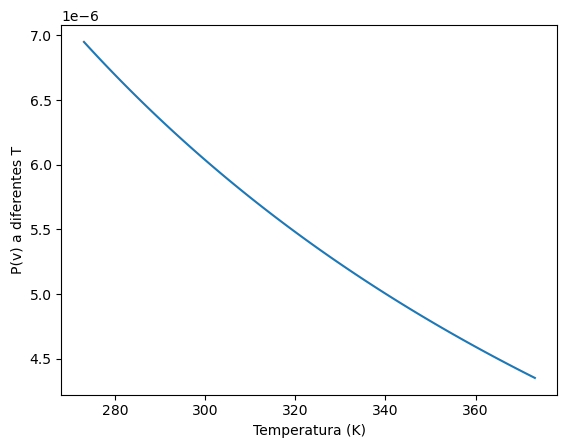

In [51]:
graficar()

In [52]:
#Punto 3.3.3

T2 = np.linspace(273.15,373.15,10)

def P_v2(x):
    
    array_vp = np.array([])
    
    for i in T2:
    
        P_v2 = (4*np.pi*((2/(2*np.pi*8.314*i))**(3/2)))*(x**3)*np.exp((-2*(x**2))/(2*8.314*i))
        
        array_vp = np.append(array_vp,P_v2)
    
    return array_vp 

def valores_v_para_diferentes_T():

    valor2 = 0

    for i in range(2):
        valor2 += Pesos[i]*P_v2(Raices[i])
        
    return valor2

valor2 = valores_v_para_diferentes_T()

def graficar2():
    
    fig, ax = plt.subplots()
    ax.scatter(T2,valor2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xlabel('Temperatura (K)')
    plt.ylabel('vp a diferentes T')

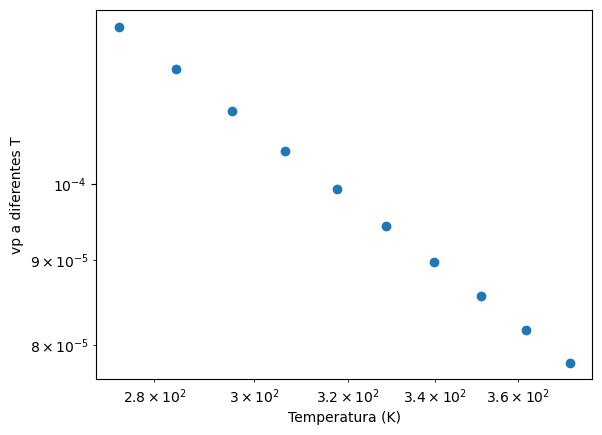

In [53]:
graficar2()

In [56]:
#Punto 3.3.4

def P_v3(x):
    
    array_vp = np.array([])
    
    for i in T2:
    
        P_v3 = np.sqrt((4*np.pi*((2/(2*np.pi*8.314*i))**(3/2)))*(x**4)*np.exp((-2*(x**2))/(2*8.314*i)))
        
        array_vp = np.append(array_vp,P_v3)
    
    return array_vp 

def valores_vrms_para_diferentes_T():

    valor3 = 0

    for i in range(2):
        valor3 += Pesos[i]*P_v3(Raices[i])
        
    return valor3

valor3 = valores_vrms_para_diferentes_T()

def graficar3():
    
    fig, ax = plt.subplots()
    ax.scatter(T2,valor3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xlabel('Temperatura (K)')
    plt.ylabel('vrms a diferentes T')

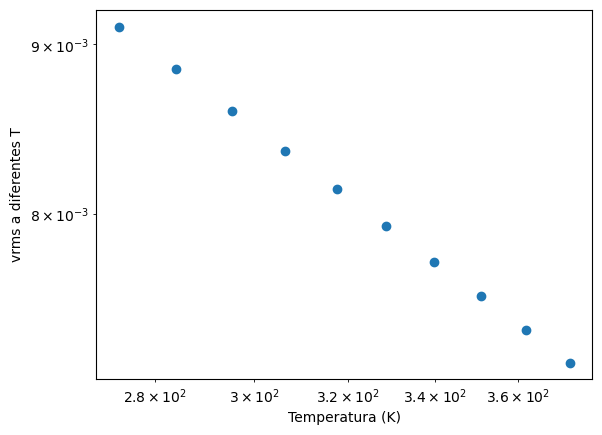

In [57]:
graficar3()